# Lab 5: Deep learning based end-to-end speech recognition 

The goal of this assignment is to get familiar with applications that require speech data as input.

We would be using the torchaudio library (pip install torchaudio==0.11.0), please carefull read this tutorial https://pytorch.org/tutorials/intermediate/speech_recognition_pipeline_tutorial.html

Next, we would ask you to perform similar analysis on a speech dataset, i.e., speechdata.zip. Unzip this folder, you would see a folder named wavs, and a file called "labels.csv", containing annotated transcripts, including the files in the wavs folder (you have more labels in labels.csv). This dataset is selected from https://keithito.com/LJ-Speech-Dataset/, a famous speech-based application benchmark.

General torchaudio tutorials: https://pytorch.org/tutorials/index.html

**Submission: submit via onq.** 


In [28]:
# Import needed libraries.
import torch
import torchaudio
import zipfile
import pandas as pd
import os
import matplotlib.pyplot as plt
import librosa
import librosa.display
import wave
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import numpy as np
import tensorflow as tf
import re
from collections import deque

print(torch.__version__)
print(torchaudio.__version__)

1.11.0+cu113
0.11.0+cu113


In [29]:
with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/Datasets/speechdata.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/Colab Notebooks/Datasets')

In [59]:
SPEECH_FILE = '/content/drive/MyDrive/Colab Notebooks/Datasets/wavs/LJ001-0019.wav'
SPEECHS_LABELS = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/labels (1).csv',sep='|',names=["File name","Text 1","Text 2"])
SPEECHS_LABELS = SPEECHS_LABELS.loc[0:99,'Text 2']

In [31]:
def clean_text(text):
    """ steps:
        - remove any html tags (< /br> often found)
        - Keep only ASCII + European Chars and whitespace, no digits
        - remove single letter chars
        - convert all whitespaces (tabs etc.) to single wspace
        if not for embedding (but e.g. tdf-idf):
        - all lowercase
        - remove stopwords, punctuation and stemm
    """
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž']", re.IGNORECASE)
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž']\b", re.IGNORECASE)
    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)
    if text[-1] == ' ':
      return text[0:-1].lower()
    else:
      return text.lower()

In [32]:
SPEECHS_LABELS = SPEECHS_LABELS.map(
    lambda x: clean_text(x) if isinstance(x, str) else x
)
SPEECHS_LABELS[56]

'parma and one or two other cities who produced the splendid editions of the classics which are one of the great glories of the printer art'

In [33]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

## Task 1: Basic data exploration
Select one randomly sampled wav file in the given folder, perform the following analysis:

1) Print the shape of the picked waveform

2) Print the sample rate of the waveform. 

3) Visualize the waveform using matplotlib

4) Create the spectrogram representation of the picked waveform and visualize it. 

5) Create the MFCC representation of the picked waveform and visualize it.

Reference: https://www.kaggle.com/code/davids1992/speech-representation-and-data-exploration/notebook 

### Task 1.1

In [34]:
waveform, sample = torchaudio.load(SPEECH_FILE)
sample_rate, samples = wavfile.read(SPEECH_FILE)
# 1)
print(f"Shape of the waveform {waveform.size()}")

Shape of the waveform torch.Size([1, 141469])


In [35]:
np_waveform = np.array(waveform).reshape(141469,)

### Task 1.2

In [36]:
print(f"Sample rate of the waveform {sample}")

Sample rate of the waveform 22050


### Task 1.3

In [37]:
wav_obj = wave.open(SPEECH_FILE, 'rb')
sample_freq = wav_obj.getframerate()
n_samples = wav_obj.getnframes()
n_channels = wav_obj.getnchannels()
signal_wave = wav_obj.readframes(n_samples)
signal_array = np.frombuffer(signal_wave, dtype=np.int16)
times = np.linspace(0, n_samples/sample_freq, num=n_samples)
l_channel = signal_array[0::2]
r_channel = signal_array[1::2]
time_l_channel = times[0::2]
time_r_channel = times[1::2]

In [38]:
signal_array

array([-27, -76, -77, ..., -58, -39,  21], dtype=int16)

#### Plot left channel

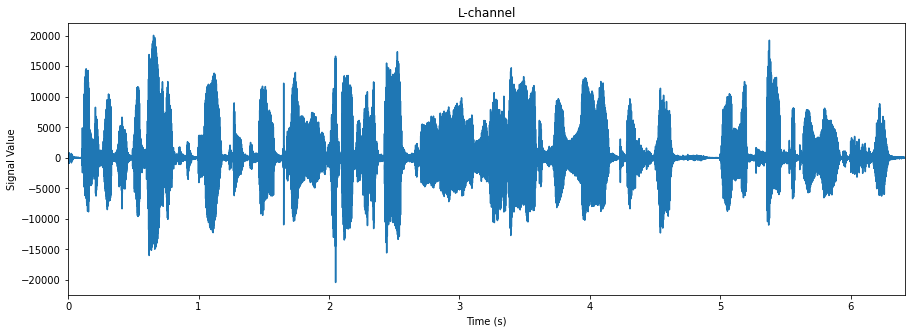

In [39]:
plt.figure(figsize=(15, 5))
plt.plot(time_l_channel, l_channel)
plt.title('L-channel')
plt.ylabel('Signal Value')
plt.xlabel('Time (s)')
plt.xlim(0, n_samples/sample_freq)
plt.show()

#### Plot right channel

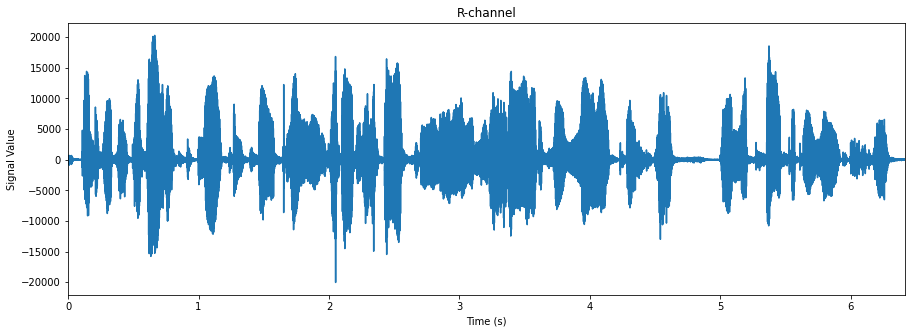

In [40]:
plt.figure(figsize=(15, 5))
plt.plot(time_r_channel, r_channel)
plt.title('R-channel')
plt.ylabel('Signal Value')
plt.xlabel('Time (s)')
plt.xlim(0, n_samples/sample_freq)
plt.show()

### Plot wave form

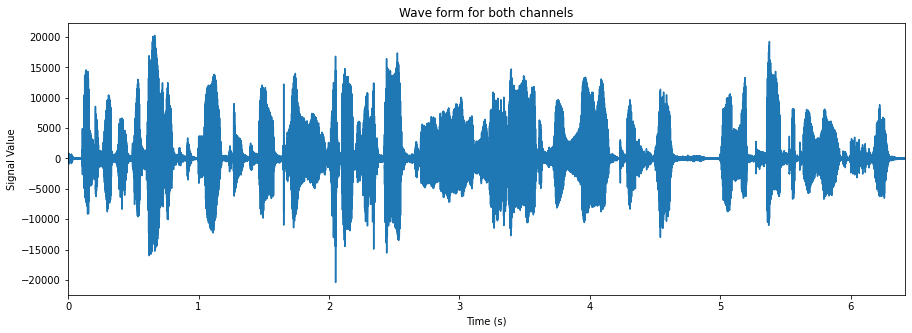

In [41]:
plt.figure(figsize=(15, 5))
plt.plot(times, signal_array)
plt.title('Wave form for both channels')
plt.ylabel('Signal Value')
plt.xlabel('Time (s)')
plt.xlim(0, n_samples/sample_freq)
plt.show()

### Task 1.4

#### spectrogram representation

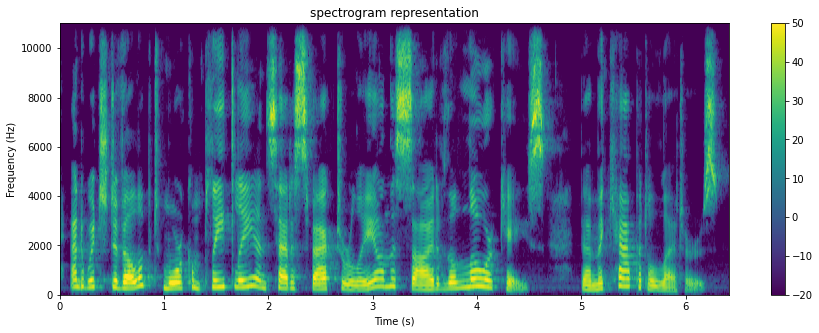

In [42]:
plt.figure(figsize=(15, 5))
plt.specgram(signal_array, Fs=sample_freq, vmin=-20, vmax=50)
plt.title('spectrogram representation')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.xlim(0, n_samples/sample_freq)
plt.colorbar()
plt.show()

### Task 1.5

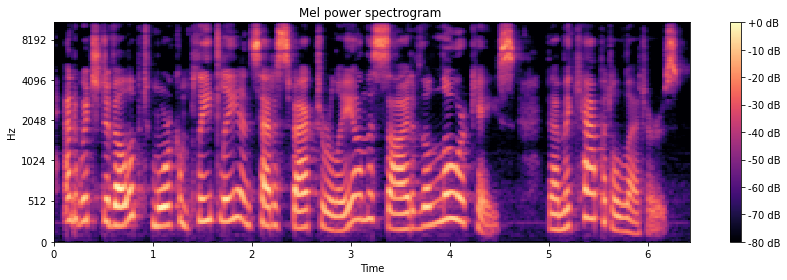

In [43]:
S = librosa.feature.melspectrogram(np_waveform, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

#### MFCC representation

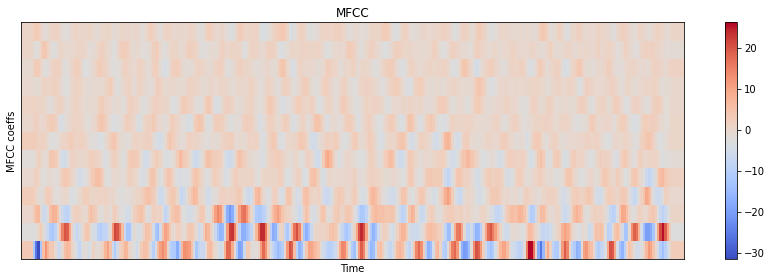

In [44]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

## Task 2: Creating a Wav2Vec2 model that can perform feature extraction and classification.


In [45]:
# TODO code for task 2
bundel = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
print(f"Sample rate: {bundel.sample_rate}")

model = bundel.get_model()
labels = bundel.get_labels()
waveform = torchaudio.functional.resample(waveform, sample_rate, bundel.sample_rate)
model

Sample rate: 16000


Wav2Vec2Model(
  (feature_extractor): FeatureExtractor(
    (conv_layers): ModuleList(
      (0): ConvLayerBlock(
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
      )
      (1): ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      )
      (2): ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      )
      (3): ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      )
      (4): ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      )
      (5): ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
      )
      (6): ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
      )
    )
  )
  (encoder): Encoder(
    (feature_projection): FeatureProjec

## Task 3: Extract acoustic features and generate predicted transcript for each waveform in the given dataset

In [46]:
# TODO code for task 3
emissions, _ = model(waveform)

class GreedyCTCDecoder(torch.nn.Module):
  def __init__(self ,labels, blank = 0) -> None:
      super().__init__()
      self.labels = labels
      self.blank = blank
  def forward(self,file_name, emission: torch.Tensor) -> str:
    indices = torch.argmax(emission, dim = -1)
    #print('argmax', indices)
    indices = torch.unique_consecutive(indices, dim = -1)
    #print("\nunique_consecutive", indices)
    indices = [i for i in indices if i != self.blank]
    transcript = file_name+" transcript: "+ "".join([self.labels[i] for i in indices])
    transcript = transcript.replace("|",' ')
    print(transcript)
    return "".join([self.labels[i] for i in indices])


decoder = GreedyCTCDecoder(labels = bundel.get_labels())
transcript = decoder('LJ001-0045.wav',emissions[0])

LJ001-0045.wav transcript: AND WHICH DEVELOPED MORE COMPLETELY AND SATISFACTORILY ON THE SIDE OF THE LOWER CASE THAN THE CAPITAL LETTERS 


In [47]:
# Getting the current work directory (cwd)
features_memory = deque(maxlen = 15)
thisdir = '/content/drive/MyDrive/Colab Notebooks/Datasets/wavs'
wav_files = []
transcripts = []
acoustic_features = []
# r=root, d=directories, f = files
for r, d, f in os.walk(thisdir):
    for file in f:
        if file.endswith(".wav"):
            wav_files.append(os.path.join(r, file))

wav_files = sorted(wav_files, key=lambda x: int(x.split('-')[1][0:4]))

for i in range(len(wav_files)):
  file_name = wav_files[i].split('/')[-1]
  waveform, sample = torchaudio.load(wav_files[i])
  waveform = torchaudio.functional.resample(waveform, sample_rate, bundel.sample_rate)
  emissions, _ = model(waveform)
  features, _ = model.extract_features(waveform)
  #acoustic features in deque data structure in order to prevent memory crash.
  features_memory.append(features)
  #transcripts
  transcript = decoder(file_name,emissions[0])
  transcript = transcript.replace("|"," ")
  transcripts.append(transcript.lower())


LJ001-0001.wav transcript: PRINTING IN THE ONLY SENSE WITH WHICH WE ARE AT PRESENT CONCERNED DIFFERS FROM MOST IF NOT FROM ALL THE ARTS AND CRAFTS REPRESENTED IN THE EXHIBITION 
LJ001-0002.wav transcript: IN BEING COMPARATIVELY MODERN 
LJ001-0003.wav transcript: FOR ALTHOUGH THE CHINESE TOOK IMPRESSIONS FROM WOOD BLOCKS ENGRAVED IN RELIEF FOR CENTURIES BEFORE THE WOOD CUTTERS OF THE NETHERLANDS BY A SIMILAR PROCESS 
LJ001-0004.wav transcript: PRODUCED THE BLOCK BOOKS WHICH WERE THE IMMEDIATE PREDECESSORS OF THE TRUE PRINTED BOOK 
LJ001-0005.wav transcript: THE INVENTION OF MOVABLE METAL LETTERS IN THE MIDDLE OF THE FIFTEENTH CENTURY MAY JUSTLY BE CONSIDERED AS THE INVENTION OF THE ART OF PRINTING 
LJ001-0006.wav transcript: AND IT IS WORTH MENTION IN PASSING THAT AS AN EXAMPLE OF FINE TYPOGRAPHY 
LJ001-0007.wav transcript: THE EARLIEST BOOK PRINTED WITH MOVABLE TYPES THE GUTTENBERG OR FORTY TWO LINE BIBLE OF ABOUT FOURTEEN FIFTY FIVE 
LJ001-0008.wav transcript: HAS NEVER BEEN SURPASSED

### plot random acoustic features for random wav file.

In [58]:
random_wav_file = np.random.randint(0,15)

fig, ax = plt.subplots(len(features_memory[random_wav_file]), 1, figsize=(16, 4.3 * len(features_memory[random_wav_file])))
print(f"features plots for file {random_wav_file}")
for i, feats in enumerate(features_memory[random_wav_file]):
    ax[i].imshow(feats[0].detach().numpy())
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
plt.tight_layout()
plt.show()


features plots for file 12


## Task 4: evaluate the performance of the trained model on the testing dataset using Word Error Rate (WER), Match Error Rate (MER)

Hint: consider this package, https://pypi.org/project/jiwer/

In [48]:
#!pip install jiwer
from jiwer import wer, mer
match_error_rate = []
word_error_rate = []

for i in range(len(SPEECHS_LABELS)):
  match_error_rate.append(mer(SPEECHS_LABELS[i],transcripts[i]))
  word_error_rate.append(wer(SPEECHS_LABELS[i],transcripts[i]))

print(match_error_rate)
print(word_error_rate)

[0.0, 0.0, 0.12, 0.0, 0.0, 0.0, 0.05263157894736842, 0.0, 0.0, 0.10526315789473684, 0.0, 0.11764705882352941, 0.125, 0.06451612903225806, 0.03571428571428571, 0.08333333333333333, 0.0, 0.13636363636363635, 0.0, 0.0, 0.1, 0.1111111111111111, 0.16666666666666666, 0.09523809523809523, 0.05555555555555555, 0.1111111111111111, 0.041666666666666664, 0.18181818181818182, 0.0, 0.15789473684210525, 0.125, 0.05555555555555555, 0.15, 0.0, 0.07692307692307693, 0.16666666666666666, 0.0, 0.16666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11764705882352941, 0.0, 0.0, 0.0, 0.1111111111111111, 0.0, 0.07142857142857142, 0.0, 0.13333333333333333, 0.0, 0.1111111111111111, 0.2631578947368421, 0.0, 0.038461538461538464, 0.0, 0.0, 0.05263157894736842, 0.0, 0.0, 0.0, 0.125, 0.1, 0.09523809523809523, 0.058823529411764705, 0.1111111111111111, 0.25, 0.0, 0.05263157894736842, 0.0, 0.0, 0.0, 0.05263157894736842, 0.0, 0.041666666666666664, 0.0, 0.1, 0.058823529411764705, 0.2727272727272727, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

## Task 5: check files with the worst performance and perform a simple error analysis, e.g., what are the files having worser performance, and what are the potential reasons, do they share any common patterns?


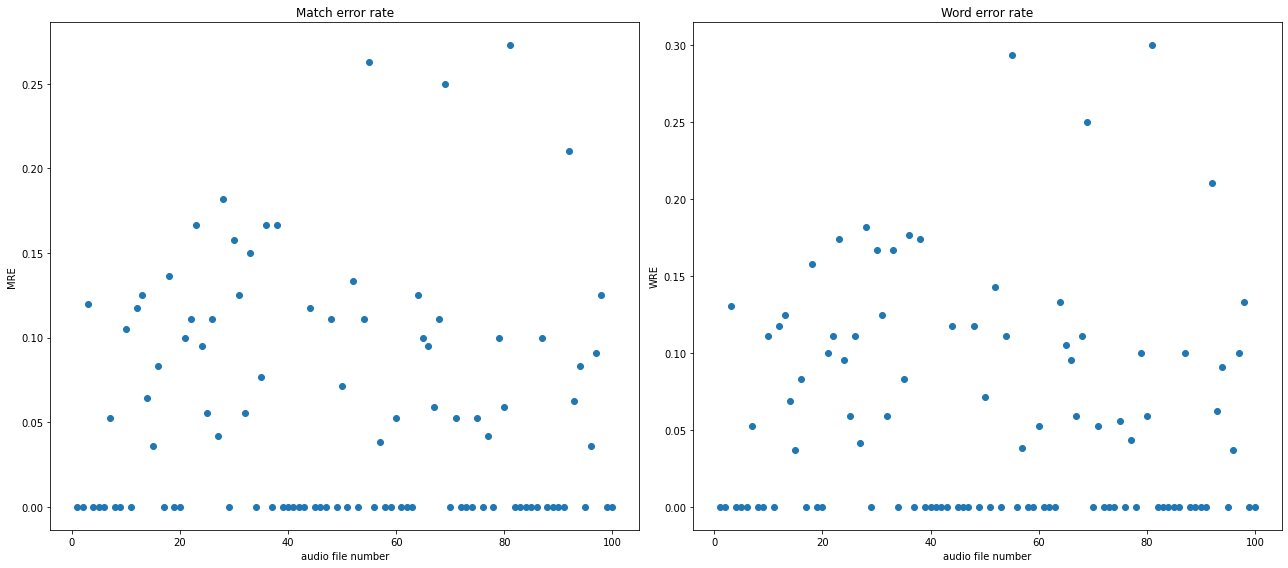

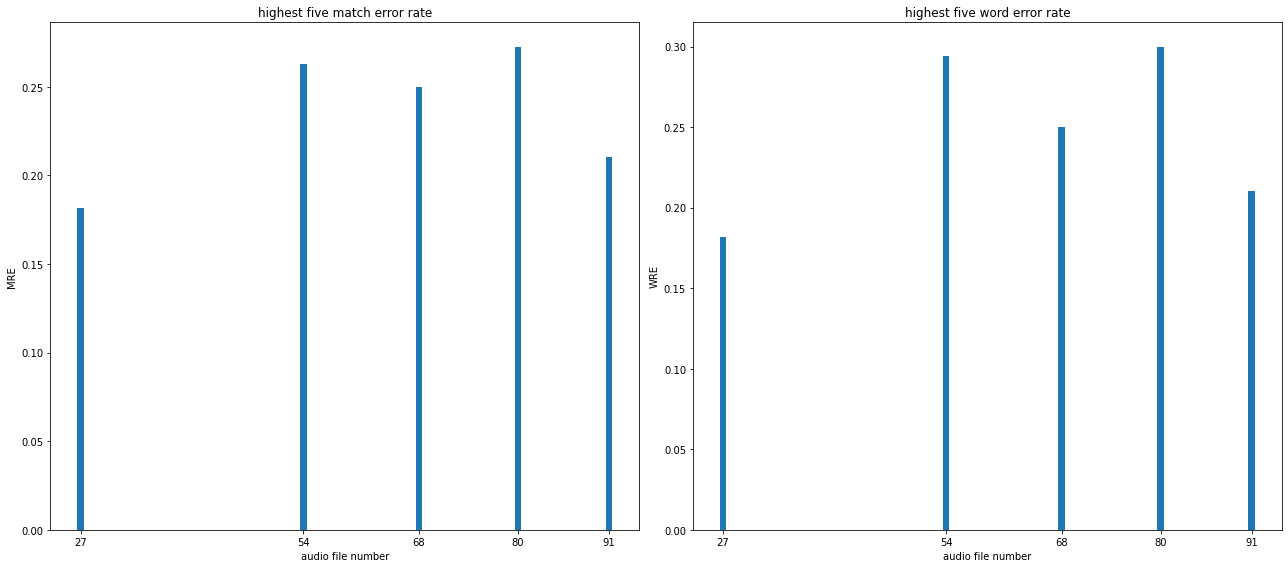

Top 5 highest match error rates

audio file 27 has 0.18181818181818182 match error rate
audio file 91 has 0.21052631578947367 match error rate
audio file 68 has 0.25 match error rate
audio file 54 has 0.2631578947368421 match error rate
audio file 80 has 0.2727272727272727 match error rate

Top 5 highest word error rates

audio file 27 has 0.18181818181818182 word error rate
audio file 91 has 0.21052631578947367 word error rate
audio file 68 has 0.25 word error rate
audio file 54 has 0.29411764705882354 word error rate
audio file 80 has 0.3 word error rate


In [49]:
# TODO code for task 5

highest_match_error_rate = sorted(match_error_rate)[-5:]
highest_word_error_rate = sorted(word_error_rate)[-5:]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,8)) 
ax1.scatter(np.arange(1,101), match_error_rate)
ax1.set_title('Match error rate')
ax1.set_ylabel('MRE')
ax1.set_xlabel('audio file number')

ax2.scatter(np.arange(1,101), word_error_rate)
ax2.set_title('Word error rate')
ax2.set_ylabel('WRE')
ax2.set_xlabel('audio file number')
plt.tight_layout()
plt.show()

MRE_highest_index = []
WRE_highest_index = []
for i in range(len(highest_match_error_rate)):
   MRE_highest_index.append(match_error_rate.index(highest_match_error_rate[i]))

   WRE_highest_index.append(word_error_rate.index(highest_word_error_rate[i]))


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,8)) 
ax1.bar(MRE_highest_index, highest_match_error_rate)
ax1.set_title('highest five match error rate')
ax1.set_ylabel('MRE')
ax1.set_xlabel('audio file number')
ax1.set_xticks(MRE_highest_index) 

ax2.bar(WRE_highest_index, highest_word_error_rate)
ax2.set_title('highest five word error rate')
ax2.set_ylabel('WRE')
ax2.set_xlabel('audio file number')
ax2.set_xticks(WRE_highest_index) 

plt.tight_layout()
plt.show()

print("Top 5 highest match error rates\n")

for i in range(len(MRE_highest_index)):
  print(f"audio file {MRE_highest_index[i]} has {highest_match_error_rate[i]} match error rate")

print("\nTop 5 highest word error rates\n")
for i in range(len(WRE_highest_index)):
  print(f"audio file {WRE_highest_index[i]} has {highest_word_error_rate[i]} word error rate")

In [50]:
WRE_predicted = []
MRE_predicted = []
WRE_groundtruth = []
MRE_groundtruth = []
for i in range(len(WRE_highest_index)):
 WRE_predicted.append(transcripts[WRE_highest_index[i]])
 MRE_predicted.append(transcripts[MRE_highest_index[i]])
 WRE_groundtruth.append(SPEECHS_LABELS[MRE_highest_index[i]])
 MRE_groundtruth.append(SPEECHS_LABELS[MRE_highest_index[i]])

WRE_data = {'audio file number': WRE_highest_index,
        'word error rate': highest_word_error_rate,
        'predicted speech transcript': WRE_predicted,
        'ground truth speech transcript': WRE_groundtruth
        }


MRE_data = {'audio file number': MRE_highest_index,
        'word error rate': highest_match_error_rate,
        'predicted speech transcript': MRE_predicted,
        'ground truth speech transcript': MRE_groundtruth
        }

WRE_table = pd.DataFrame(WRE_data)
MRE_table = pd.DataFrame(MRE_data)


In [51]:
WRE_table

audio file number  word error rate  \
0                 27         0.181818   
1                 91         0.210526   
2                 68         0.250000   
3                 54         0.294118   
4                 80         0.300000   

                         predicted speech transcript  \
0  but by printers in strasburg besel paris lubec...   
1  the chiswick press in eighteen forty four revi...   
2  this type was introduced into england by winke...   
3  some of which as e g that of jacobis rubius or...   
4  type cast from his matresses is still in every...   

                      ground truth speech transcript  
0  but by printers in strasburg basle paris lubec...  
1  the chiswick press in eighteen forty four revi...  
2  this type was introduced into england by wynky...  
3  some of which as that of jacobus rubeus or jac...  
4  type cast from his matrices is still in everyd...

In [52]:
MRE_table

audio file number  word error rate  \
0                 27         0.181818   
1                 91         0.210526   
2                 68         0.250000   
3                 54         0.263158   
4                 80         0.272727   

                         predicted speech transcript  \
0  but by printers in strasburg besel paris lubec...   
1  the chiswick press in eighteen forty four revi...   
2  this type was introduced into england by winke...   
3  some of which as e g that of jacobis rubius or...   
4  type cast from his matresses is still in every...   

                      ground truth speech transcript  
0  but by printers in strasburg basle paris lubec...  
1  the chiswick press in eighteen forty four revi...  
2  this type was introduced into england by wynky...  
3  some of which as that of jacobus rubeus or jac...  
4  type cast from his matrices is still in everyd...

### Why they are have high error rates?

Actually, They are haven't any common patterns, they are just random texts but the only common thing between these texts is that they have words that can be pronounced by more than one character, like **(rubeus)** the model classified it as **(rubius)** because they have the same pronunciation but the specified metric considered this as an error and that's the main reason.